In [ ]:
import scipy
import numpy as np
from rdkit import Chem
from tdc.single_pred import Tox
import pandas as pd
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from ..utils.utils import balanced, create_scaffold_split

# get data
data = Tox(name = 'herg_karim')

df = data.get_data(format = 'df')

# # get the splits
# split = create_scaffold_split(df, seed = 254, frac = [0.7, 0.1, 0.1, 0.1], entity = data.entity1_name)
#
# # balance the data
# split_balanced = balanced(split[data_split], oversample=True, seed=254)
#
# data_split = data_split
#
# if data_split == 'train' or data_split == 'valid':
#     # return the balanced data for training and validation sets
#
#     drug = split_balanced['Drug']
#
#     label = split_balanced['Y']
# else:
#     drug = split[data_split]['Drug']
#
#     label = split[data_split]['Y']


Found local copy...
Loading...
Done!


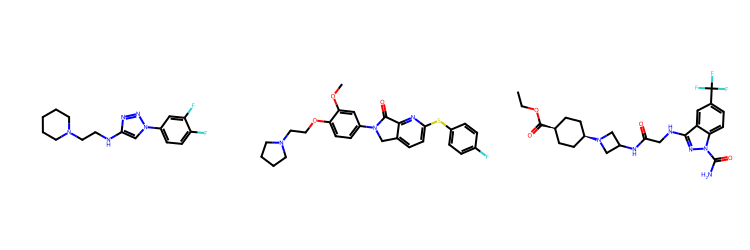

In [47]:
# let's look at what a SMILEs string represents

ms = [Chem.MolFromSmiles(smi) for smi in df['Drug'][0:3]]
img = Draw.MolsToGridImage(ms, molsPerRow=3, subImgSize=(250, 250), maxMols=3,
                           legends=None, useSVG=True)
img

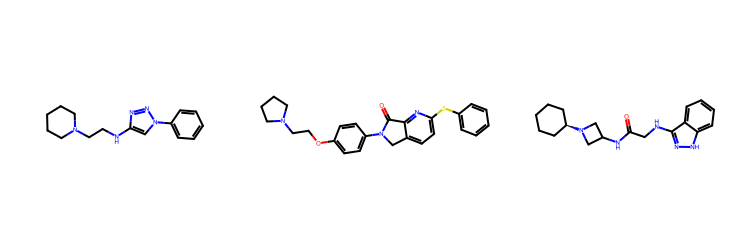

In [49]:
# example of Murcko scaffolds
from rdkit.Chem.Scaffolds import MurckoScaffold

ms = [MurckoScaffold.GetScaffoldForMol(m) for m in ms]
img = Draw.MolsToGridImage(ms, molsPerRow=3, subImgSize=(250, 250), maxMols=3,
                           legends=None, useSVG=True)
img

In [15]:
def get_atom_features(atom):
    atom_type = str(atom.GetSymbol())
    n_heavy_neighbors = int(atom.GetDegree())
    formal_charge = int(atom.GetFormalCharge())
    hybridisation_type = str(atom.GetHybridization())
    is_in_a_ring = int(atom.IsInRing())
    is_aromatic = int(atom.GetIsAromatic())
    atomic_mass_scaled = float((atom.GetMass() - 10.812) / 116.092)
    vdw_radius_scaled = float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5) / 0.6)
    covalent_radius_scaled = float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64) / 0.76)
    chirality_type = str(atom.GetChiralTag())
    n_hydrogens = int(atom.GetTotalNumHs())

    return atom_type, [is_in_a_ring, is_aromatic], [n_heavy_neighbors, formal_charge, hybridisation_type, atomic_mass_scaled, vdw_radius_scaled, covalent_radius_scaled, chirality_type, n_hydrogens]


In [16]:
atom_features = []
binary_atom_feat = []
atom_types = []
atom_label = []
num_atoms = []
num_bonds = []

for i, (sample, label) in enumerate(zip(df['Drug'], df['Y'])):
    mol = Chem.MolFromSmiles(sample)
    n_nodes = mol.GetNumAtoms()
    n_edges = 2*mol.GetNumBonds()
    num_atoms.append(n_nodes)
    num_bonds.append(n_edges)

    for atom in mol.GetAtoms():
        type, bin_feat, feat = get_atom_features(atom)
        atom_types.append(type)
        feat.append(label)
        atom_features.append(feat)
        atom_label.append(label)
        bin_feat.append(label)
        binary_atom_feat.append(bin_feat)



In [17]:
# get the mean and sd for the number of atoms and the number of bonds
# create the DataFrame
agg_mol = pd.DataFrame({'Label': df['Y'], 'NumAtoms': num_atoms, 'NumBonds': num_bonds})

# Compute the mean and standard deviation of features factored by 'Label'
df_means = agg_mol.groupby('Label').mean().reset_index()

df_stds = agg_mol.groupby('Label').std().reset_index()

# Combine the mean and standard deviation DataFrames into one
df_combined = pd.DataFrame({'Feature': df_means.columns[1:],
                            'Mean ± Std (Non hERG)': [f'{df_means.iloc[0,i]:.2f} ± {df_stds.iloc[0,i]:.2f}' for i in range(1, len(df_means.columns))],
                            'Mean ± Std (hERG)': [f'{df_means.iloc[1,i]:.2f} ± {df_stds.iloc[1,i]:.2f}' for i in range(1, len(df_means.columns))]})



df_combined.to_csv('tables/mol_eda.csv', float_format='%.3f', index = None)

   Label   NumAtoms   NumBonds
0      0  30.700758  67.596551
1      1  31.079190  68.690086


In [45]:
atom_mat = pd.DataFrame(atom_features)
atom_mat.columns =  ["NumHeavyNeighbors", "FormalCharge", "HybridisationType",
               "AtomicMassScaled", "VDWRadiusScaled", "CovalentRadiusScaled", "ChiralityType",
               "NumHydrogens", "Label"]

# Compute the mean and standard deviation of features factored by 'Label'
df_means = atom_mat.groupby('Label').mean().reset_index()
df_stds = atom_mat.groupby('Label').std().reset_index()

# Combine the mean and standard deviation DataFrames into one
df_combined = pd.DataFrame({'Feature': df_means.columns[1:],
                            'Mean ± Std (Non hERG)': [f'{df_means.iloc[0,i]:.2f} ± {df_stds.iloc[0,i]:.2f}' for i in range(1, len(df_means.columns))],
                            'Mean ± Std (hERG)': [f'{df_means.iloc[1,i]:.2f} ± {df_stds.iloc[1,i]:.2f}' for i in range(1, len(df_means.columns))]})

bin_mat = pd.DataFrame(binary_atom_feat)
bin_mat.columns = ["IsRing","IsAromatic","Label"]

# Compute the mean and standard deviation of features factored by 'Label'
df_frac = bin_mat.groupby('Label').mean().reset_index()

df_frac['Label'] = ['hERG' if x == 1 else 'non-hERG' for x in df_frac['Label']]
df_frac.set_index(['Label']).reset_index()

df_combined.to_csv('tables/atom_eda.csv', float_format='%.3f', index = None)

df_frac.to_csv('tables/atom_binary_eda.csv', float_format='%.3f', index = None)

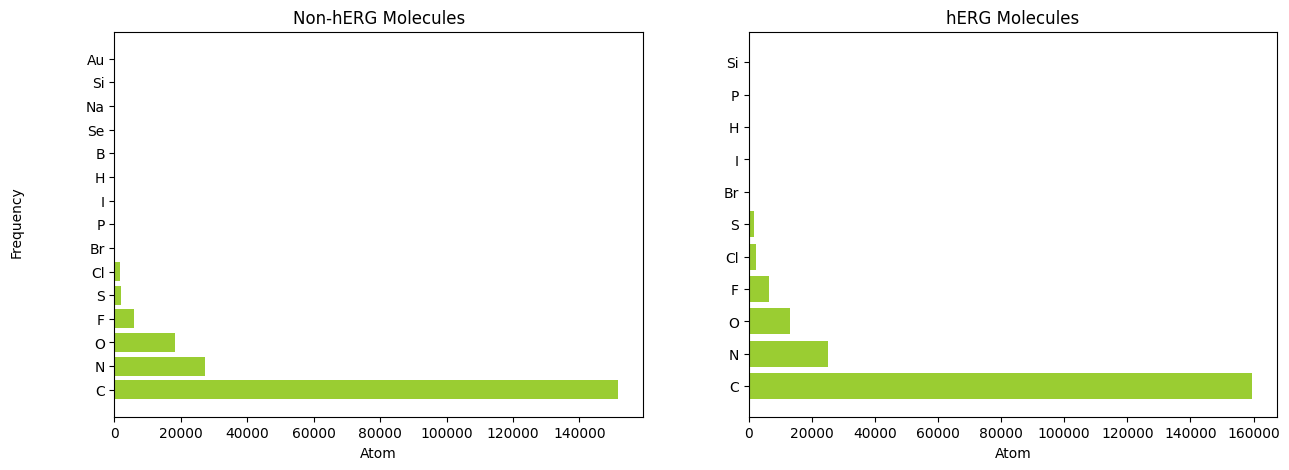

In [87]:


hist_data = pd.DataFrame({'Label': atom_label,
                     'Atom': atom_types})

# list of permitted atoms for the Y axis labels
permitted_list_of_atoms = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'As', 'Al', 'I',
                           'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'Li', 'Ge',
                           'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb', 'Unknown']

# group dataframe by label
grouped = hist_data.groupby('Label')

# create a subplot with 2 columns
fig, axs = plt.subplots(ncols=2, figsize = (15,5))

fig.text(0.06, 0.5, 'Frequency', ha='center', va='center', rotation='vertical')

# loop through each group and create a bar plot for the count of strings
for i, (label, group) in enumerate(grouped):
    ax = axs[i%2] # alternate between the two columns
    if label == 0:
        ax.set_title(f'Non-hERG Molecules')
    else:
        ax.set_title("hERG Molecules")
    ax.barh(group['Atom'].value_counts().index, group['Atom'].value_counts().values, color = "yellowgreen")
    ax.set_xlabel('Atom')

plt.savefig("figures/atom_dist.png")